<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/demo/notebook/01a_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from  xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import sys
import requests 
import io
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing csv 

In [ ]:
url = "https://raw.githubusercontent.com/Jarvis-BITS/midodrine-mimic-iv/demo/data/table_cohort.csv"
download = requests.get(url).content

In [ ]:
cohort_table = pd.read_csv(io.StringIO(download.decode('utf-8')))
cohort_table

,stay_id,hadm_id,subject_id,age,Gender,ethnicity,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
0,36014877,27162817,11861017,87,0,WHITE,1,1.595745,0,1,...,17.600000,36.416667,100.000000,247.375000,1.0,1.0,1,0,0,15
1,32272859,25963696,11259141,60,1,WHITE,1,1.633333,0,7,...,17.333333,36.898333,97.259259,120.200000,1.0,1.0,1,0,0,18
2,34023828,21782431,18010960,59,0,UNKNOWN,1,1.589041,0,1,...,15.392857,36.786667,96.629630,98.000000,1.0,1.0,1,0,0,15
3,37798199,29764966,10926537,42,1,BLACK/AFRICAN AMERICAN,1,1.568627,0,7,...,17.240000,37.142857,99.791667,95.000000,1.0,1.0,1,0,0,17
4,32309766,29272306,15703353,59,1,WHITE,1,1.517241,0,6,...,21.740741,37.372000,98.178571,136.800000,1.0,1.0,1,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35295,39955170,24679700,12799579,55,1,WHITE,0,1.464286,1,7,...,24.148148,37.325000,94.115385,148.333333,0.0,1.0,1,0,0,19
35296,39977793,20968809,13886051,66,1,WHITE,0,1.407407,1,3,...,14.400000,36.646364,97.205882,96.333333,0.0,1.0,1,1,1,19
35297,39980385,21253505,11392990,73,0,WHITE,0,1.592593,1,5,...,19.605263,36.835000,93.605263,203.200000,0.0,1.0,1,1,0,6
35298,39985296,29295929,19632565,59,1,WHITE,0,1.782609,1,2,...,25.692308,36.603333,96.296296,173.400000,0.0,1.0,1,1,1,15


In [ ]:
cohort_table.columns

Index(['stay_id', 'hadm_id', 'subject_id', 'age', 'Gender', 'ethnicity',
       'midodrine', 'avg_doses_per_24_hrs', 'MICU', 'adm_weekday', 'weight',
       'sapsii', 'charlson_index', 'CPD_or_COPD_rate', 'Maligancy_rate',
       'mild_liver_rate', 'severe_liver_rate', 'Renal_rate', 'CAD_rate',
       'AFIB_rate', 'hemoglobin', 'platelet', 'wbc', 'sodium', 'potassium',
       'bicarbonate', 'chloride', 'bun', 'creatinine', 'lactate', 'ph', 'po2',
       'pco2', 'bnp', 'troponin', 'creatinine_kinase', 'heart_rate_mean',
       'sbp_mean', 'dbp_mean', 'mbp_mean', 'resp_rate_mean',
       'temperature_mean', 'spo2_mean', 'glucose_mean', 'sedative_use',
       'ventilation_use', 'vasopressor_use', 'mortality', 'mort_28_day',
       'admit_hour'],
      dtype='object')

In [ ]:
cohort_table.describe()

,stay_id,hadm_id,subject_id,age,Gender,midodrine,avg_doses_per_24_hrs,MICU,adm_weekday,weight,...,resp_rate_mean,temperature_mean,spo2_mean,glucose_mean,sedative_use,ventilation_use,vasopressor_use,mortality,mort_28_day,admit_hour
count,3.530000e+04,3.530000e+04,3.530000e+04,35300.000000,35300.000000,35300.000000,35184.000000,35300.000000,35300.000000,34620.000000,...,35235.000000,34986.000000,35214.000000,34326.000000,35113.000000,25512.0,35300.0,35300.000000,35300.000000,35300.000000
mean,3.498390e+07,2.497613e+07,1.499966e+07,62.705694,0.469830,0.022946,1.622051,0.534334,3.992663,80.654058,...,19.282602,36.878330,96.686357,260.224735,0.392647,1.0,1.0,0.172550,0.111841,12.855581
std,2.892380e+06,2.889905e+06,2.887420e+06,18.424232,0.499096,0.149734,0.357446,0.498827,1.995172,26.148795,...,3.934879,0.543675,2.634797,7141.871173,0.488346,0.0,0.0,0.377863,0.315176,7.540701
min,3.000015e+07,2.000035e+07,1.000003e+07,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,6.000000,30.400000,26.600000,34.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000
25%,3.245169e+07,2.247389e+07,1.249361e+07,51.000000,0.000000,0.000000,1.400000,0.000000,2.000000,64.700000,...,16.500000,36.626278,95.542857,107.333333,0.000000,1.0,1.0,0.000000,0.000000,5.000000
50%,3.499433e+07,2.494200e+07,1.501041e+07,64.000000,0.000000,0.000000,1.575000,1.000000,4.000000,77.100000,...,18.653846,36.853333,96.941176,129.000000,0.000000,1.0,1.0,0.000000,0.000000,15.000000
75%,3.748920e+07,2.747473e+07,1.750540e+07,77.000000,1.000000,0.000000,1.794872,1.000000,6.000000,92.300000,...,21.454545,37.135714,98.315789,159.750000,1.000000,1.0,1.0,0.000000,0.000000,19.000000
max,3.999938e+07,2.999962e+07,1.999999e+07,102.000000,1.000000,1.000000,9.250000,1.000000,7.000000,1120.000000,...,48.000000,40.104118,100.000000,999999.000000,1.000000,1.0,1.0,1.000000,1.000000,23.000000


In [ ]:
cohort_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35300 entries, 0 to 35299
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stay_id               35300 non-null  int64  
 1   hadm_id               35300 non-null  int64  
 2   subject_id            35300 non-null  int64  
 3   age                   35300 non-null  int64  
 4   Gender                35300 non-null  int64  
 5   ethnicity             35300 non-null  object 
 6   midodrine             35300 non-null  int64  
 7   avg_doses_per_24_hrs  35184 non-null  float64
 8   MICU                  35300 non-null  int64  
 9   adm_weekday           35300 non-null  int64  
 10  weight                34620 non-null  float64
 11  sapsii                26683 non-null  float64
 12  charlson_index        35300 non-null  float64
 13  CPD_or_COPD_rate      35300 non-null  float64
 14  Maligancy_rate        35300 non-null  float64
 15  mild_liver_rate    

In [ ]:
cohort_table = cohort_table.drop(columns=['ethnicity','hadm_id','subject_id'])

In [ ]:
mido_data = cohort_table.loc[cohort_table['midodrine'] == 1]
nomido_data = cohort_table.loc[cohort_table['midodrine'] == 0]

### Feature importance

In [ ]:
X = cohort_table.drop(['stay_id','mortality', 'mort_28_day', 'midodrine', 'avg_doses_per_24_hrs'], axis=1)
y = cohort_table['midodrine']

In [ ]:
seed = 20220614 #for reproducible results
test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [ ]:
#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)

In [ ]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.82%


In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model = XGBClassifier(n_estimators=300, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=seed)
    model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.987
Accuracy score (validation): 0.978
Learning rate:  0.075
Accuracy score (training): 0.991
Accuracy score (validation): 0.978
Learning rate:  0.1
Accuracy score (training): 0.995
Accuracy score (validation): 0.978
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.977
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.978
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.978


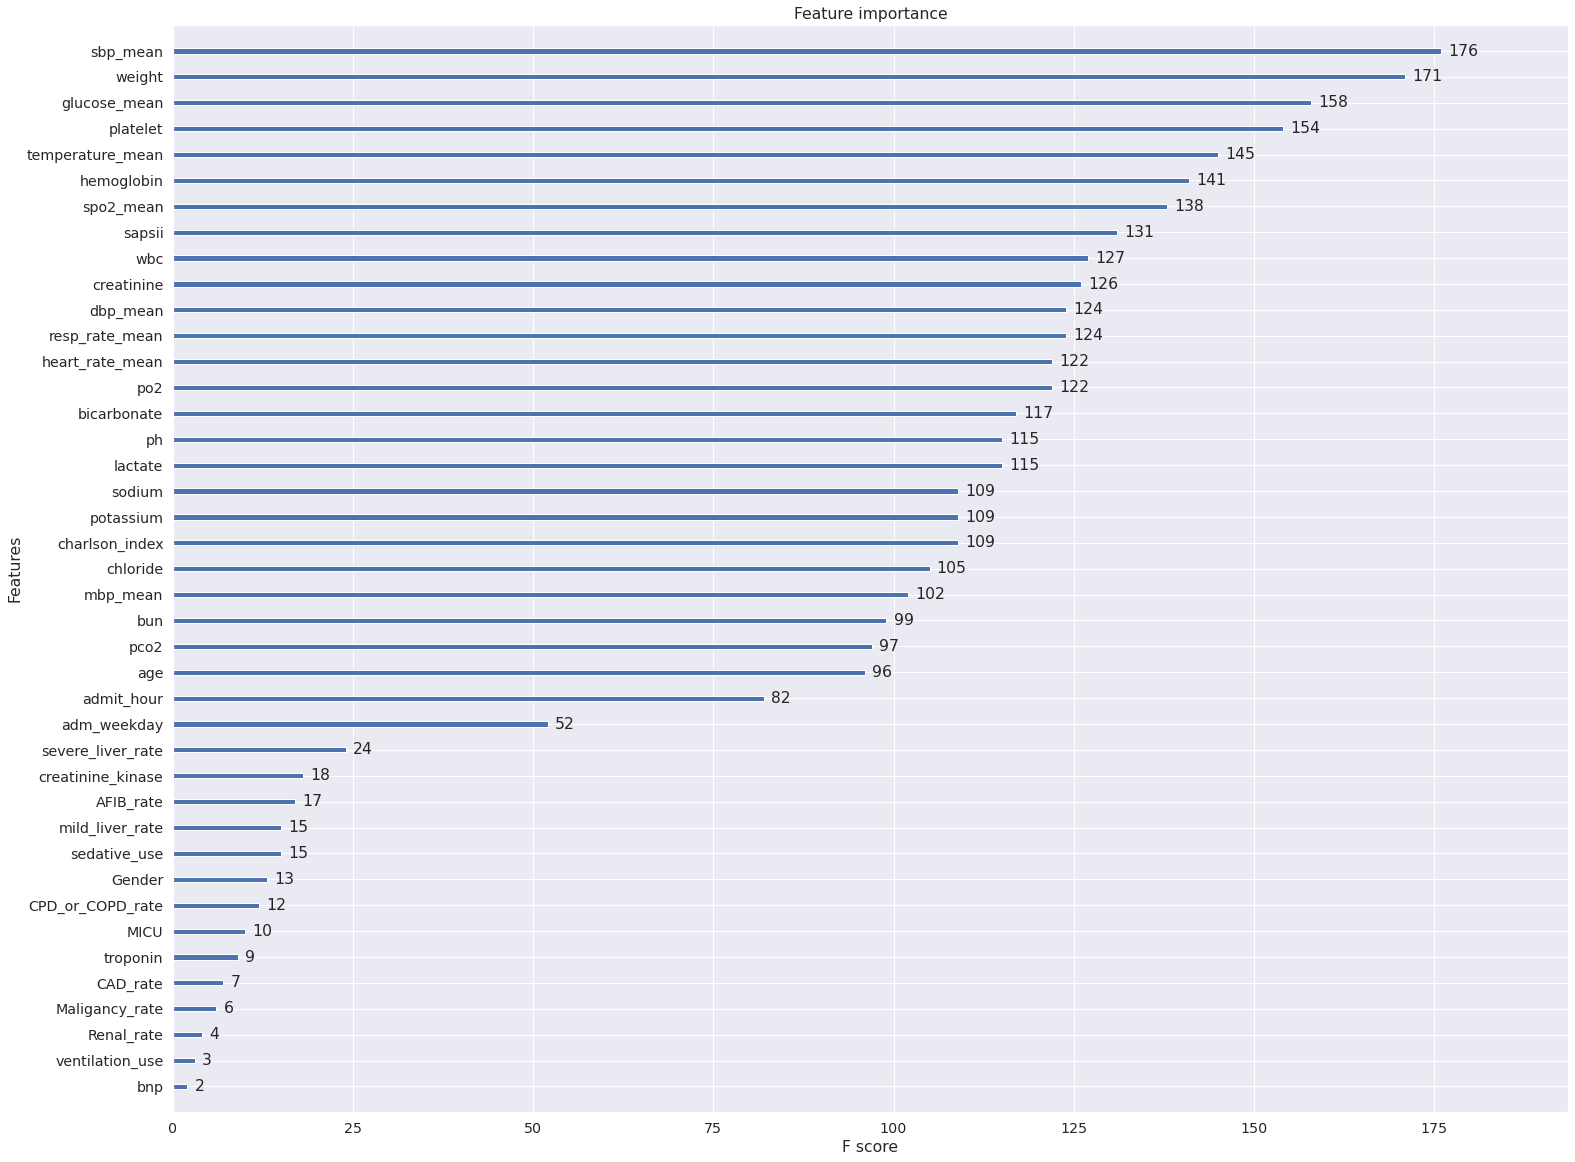

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(25,20))
plot_importance(model, ax=ax)
plt.show()